# Understanding PushWorld PLR Training - Step by Step

This notebook breaks down the PushWorld PLR (Prioritized Level Replay) training pipeline into small, atomic components so you can understand exactly how each piece works.

## Overview of PLR

PLR is a curriculum learning method that:
1. **Generates random levels** (Domain Randomization / DR)
2. **Scores levels** based on how challenging they are for the current agent
3. **Stores high-scoring levels** in a replay buffer
4. **Replays** stored levels to train the agent on difficult scenarios

The key insight: train on levels that are neither too easy nor too hard - levels where the agent is still learning.

## 1. Imports and Setup

First, let's import all the necessary libraries. We'll explain what each one does.

In [1]:
# Standard library
import sys  # noqa
from enum import IntEnum  # noqa
from typing import Sequence, Tuple  # noqa

# JAX ecosystem - for hardware-accelerated numerical computing
import jax  # noqa
import jax.numpy as jnp  # noqa
import numpy as np  # noqa

# Flax - neural network library built on JAX
import flax.linen as nn  # noqa
from flax import core, struct  # noqa
from flax.linen.initializers import constant, orthogonal  # noqa
from flax.training.train_state import TrainState as BaseTrainState  # noqa

# Optax - optimization library for JAX
import optax  # noqa

# Distrax - probability distributions for JAX
import distrax  # noqa

# Type checking
import chex  # noqa

# Add parent directory to path for imports
sys.path.insert(0, "..")

# PushWorld environment components
from jaxued.environments.pushworld import (  # noqa
    Actions,  # noqa
    EnvParams,  # noqa
    EnvState,  # noqa
    Level,  # noqa
    Observation,  # noqa
    PushWorld,  # noqa
    PushWorldRenderer,  # noqa
    make_level_generator,  # noqa
    make_level_mutator_minimax,  # noqa
    prefabs,
)  # noqa

# PLR components
from jaxued.level_sampler import LevelSampler  # noqa
from jaxued.linen import ResetRNN  # noqa
from jaxued.utils import compute_max_returns, max_mc, positive_value_loss  # noqa
from jaxued.wrappers import AutoReplayWrapper  # noqa

# For visualization
import matplotlib.pyplot as plt  # noqa

print("✓ All imports successful!")
print(f"JAX devices: {jax.devices()}")


✓ All imports successful!
JAX devices: [CpuDevice(id=0)]


## 2. Configuration

Instead of using Hydra, we'll define our config as a simple dictionary. This makes it easier to understand what each parameter controls.

In [2]:
config = {
    # === ENVIRONMENT CONFIG ===
    "grid_size": 10,  # PushWorld uses a 10x10 grid
    "penalize_time": True,  # Small negative reward per step (-0.01)
    "reward_shaping": False,  # Don't give intermediate rewards for goal progress
    "n_walls": 10,  # Number of walls in randomly generated levels
    "n_movables": 1,  # Number of movable objects (1-4)
    "max_steps_in_episode": 100,  # Max steps before episode terminates
    # === PPO HYPERPARAMETERS ===
    "lr": 1e-4,  # Learning rate
    "max_grad_norm": 0.5,  # Gradient clipping threshold
    "num_steps": 256,  # Rollout length (steps per environment before update)
    "num_train_envs": 32,  # Number of parallel environments (REDUCED for notebook)
    "num_minibatches": 1,  # Number of minibatches per update
    "gamma": 0.995,  # Discount factor
    "epoch_ppo": 5,  # Number of PPO epochs per update
    "clip_eps": 0.2,  # PPO clipping epsilon
    "gae_lambda": 0.98,  # GAE lambda parameter
    "entropy_coeff": 1e-3,  # Entropy bonus coefficient
    "critic_coeff": 0.5,  # Value loss coefficient
    # === PLR HYPERPARAMETERS ===
    "score_function": "MaxMC",  # How to score levels: "MaxMC" or "pvl"
    "exploratory_grad_updates": False,  # Update on DR levels? (Robust PLR = False)
    "level_buffer_capacity": 4000,  # Max levels in replay buffer
    "replay_prob": 0.8,  # Probability of replaying vs generating new levels
    "staleness_coeff": 0.3,  # Weight for level staleness in sampling
    "temperature": 0.3,  # Temperature for score-based sampling
    "topk_k": 4,  # K for top-k prioritization
    "minimum_fill_ratio": 0.5,  # Min buffer fill before replay starts
    "prioritization": "rank",  # "rank" or "topk"
    "buffer_duplicate_check": True,  # Check for duplicate levels
    # === ACCEL (optional) ===
    "use_accel": False,  # Use ACCEL (level mutation)?
    "num_edits": 5,  # Number of mutations per level
    # === TRAINING ===
    "seed": 42,
    "num_updates": 30000,  # Total training updates
    "eval_freq": 250,  # Evaluate every N updates
    "eval_num_attempts": 10,  # Number of eval attempts per level
    "eval_levels": [  # Levels to evaluate on
        "TrivialPush",
        "SimplePush",
        "TwoGoals",
        "ChainPush",
    ],
}

print("Configuration loaded!")
print(f"  Grid size: {config['grid_size']}x{config['grid_size']}")
print(f"  Parallel envs: {config['num_train_envs']}")
print(f"  Rollout length: {config['num_steps']} steps")
print(f"  Replay probability: {config['replay_prob']}")

Configuration loaded!
  Grid size: 10x10
  Parallel envs: 32
  Rollout length: 256 steps
  Replay probability: 0.8


## 3. Understanding the PushWorld Environment

Let's first understand what the PushWorld environment looks like and how it works.

### 3.1 The Environment

PushWorld is a puzzle game where:
- An **agent** (green) can move in 4 directions
- The agent can **push** objects
- **Movable objects** (red/blue) need to be pushed onto **goals** (light red)
- The puzzle is solved when all movables are on their corresponding goals

In [3]:
# Create the PushWorld environment
env = PushWorld(
    penalize_time=config["penalize_time"],
    reward_shaping=config["reward_shaping"],
)

# Create environment parameters
env_params = EnvParams(max_steps_in_episode=config["max_steps_in_episode"])

# Create renderer for visualization
renderer = PushWorldRenderer(env, tile_size=32, render_grid_lines=True)

print("PushWorld Environment")
print("=" * 40)
print(f"Grid size: {env.grid_size}x{env.grid_size}")
print(f"Action space: {env.action_space(env_params)}")
print(f"Observation space: {env.observation_space(env_params)}")
print(f"Max steps per episode: {env_params.max_steps_in_episode}")
print()
print("Actions:")
for action in Actions:
    print(f"  {action.value}: {action.name}")

PushWorld Environment
Grid size: 10x10
Action space: <gymnax.environments.spaces.Discrete object at 0x164e5ecf0>
Observation space: <gymnax.environments.spaces.Box object at 0x164e5ecf0>
Max steps per episode: 100

Actions:
  0: up
  1: right
  2: down
  3: left


### 3.2 Visualizing a Prefab Level

Let's load and visualize one of the built-in "prefab" puzzle levels.

In [4]:
# Load a simple prefab level
level = Level.from_str(prefabs["SimplePush"])

print("Level: SimplePush")
print("=" * 40)
print(level.to_str())
print()
print("Level structure (pytree leaves):")
print(f"  agent_pos shape: {level.agent_pos.shape} - up to 3 pixels per object")
print(f"  m1_pos shape: {level.m1_pos.shape} - movable object 1")
print(f"  g1_pos shape: {level.g1_pos.shape} - goal 1")
print(
    f"  wall_map shape: {level.wall_map.shape} - {config['grid_size']}x{config['grid_size']} boolean grid"
)
print()
print("Actual positions (x, y), -1 means unused:")
print(f"  Agent: {level.agent_pos}")
print(f"  M1: {level.m1_pos}")
print(f"  G1: {level.g1_pos}")

Level: SimplePush
W  W  W  W  W  W  W  W  W  W
W  W  W  W  W  W  W  W  W  W
W  W  .  .  .  .  .  .  W  W
W  W  .  A  .  .  .  .  W  W
W  W  .  W  W  W  .  .  W  W
W  W  .  .  M1  .  .  .  W  W
W  W  .  .  G1  .  .  .  W  W
W  W  .  .  .  .  .  .  W  W
W  W  W  W  W  W  W  W  W  W
W  W  W  W  W  W  W  W  W  W

Level structure (pytree leaves):
  agent_pos shape: (3, 2) - up to 3 pixels per object
  m1_pos shape: (3, 2) - movable object 1
  g1_pos shape: (3, 2) - goal 1
  wall_map shape: (10, 10) - 10x10 boolean grid

Actual positions (x, y), -1 means unused:
  Agent: [[ 3  3]
 [-1 -1]
 [-1 -1]]
  M1: [[ 4  5]
 [-1 -1]
 [-1 -1]]
  G1: [[ 4  6]
 [-1 -1]
 [-1 -1]]


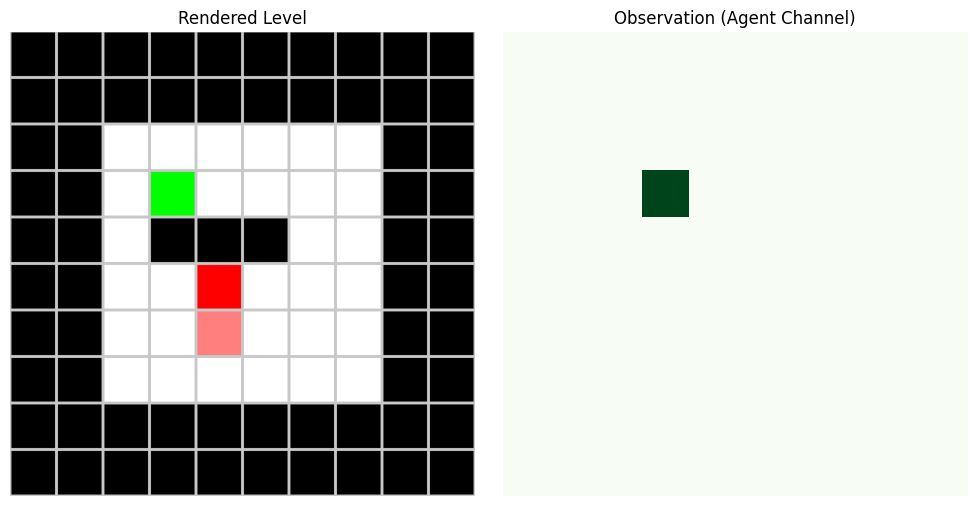


Observation shape: (10, 10, 8)
Channels: [agent, m1, m2, m3, m4, g1, g2, wall]


In [5]:
# Visualize the level
rng = jax.random.PRNGKey(0)
obs, state = env.reset_env_to_level(rng, level, env_params)

# Render and display
img = renderer.render_state(state, env_params)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left: rendered image
axes[0].imshow(np.array(img))
axes[0].set_title("Rendered Level")
axes[0].axis("off")

# Right: observation channels
# Observation is 10x10x8 - let's visualize the channels
obs_img = obs.image
axes[1].imshow(obs_img[:, :, 0], cmap="Greens")  # Agent channel
axes[1].set_title("Observation (Agent Channel)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

print(f"\nObservation shape: {obs.image.shape}")
print("Channels: [agent, m1, m2, m3, m4, g1, g2, wall]")

### 3.3 Random Level Generation

For PLR, we need to generate random levels. This is called "Domain Randomization" (DR).

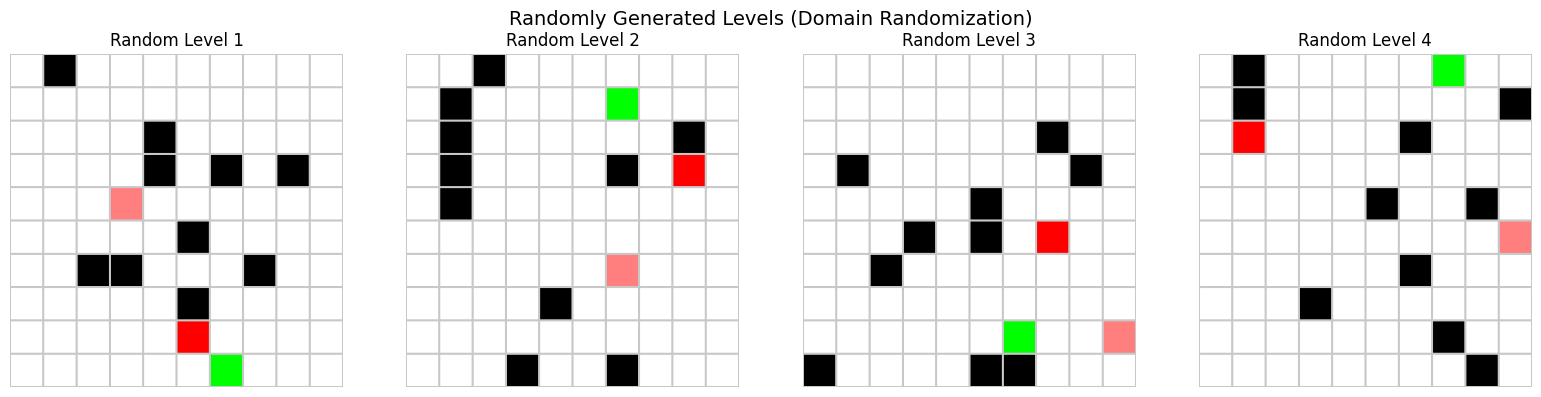


Level generator config:
  n_walls: 10
  n_movables: 1


In [7]:
# Create the level generator
sample_random_level = make_level_generator(
    height=config["grid_size"],
    width=config["grid_size"],
    n_walls=config["n_walls"],
    n_movables=config["n_movables"],
)

# Generate some random levels
rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, 4)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    random_level = sample_random_level(rngs[i])
    obs, state = env.reset_env_to_level(rngs[i], random_level, env_params)
    img = renderer.render_state(state, env_params)
    ax.imshow(np.array(img))
    ax.set_title(f"Random Level {i+1}")
    ax.axis("off")

plt.suptitle("Randomly Generated Levels (Domain Randomization)", fontsize=14)
plt.tight_layout()
plt.show()

print("\nLevel generator config:")
print(f"  n_walls: {config['n_walls']}")
print(f"  n_movables: {config['n_movables']}")

### 3.4 Taking Steps in the Environment

Let's manually step through the environment to understand the dynamics.

Episode Trace:
Step 0: Initial state
Step 1: Action=right, Reward=9.99, Done=True
Step 2: Action=right, Reward=-0.01, Done=False


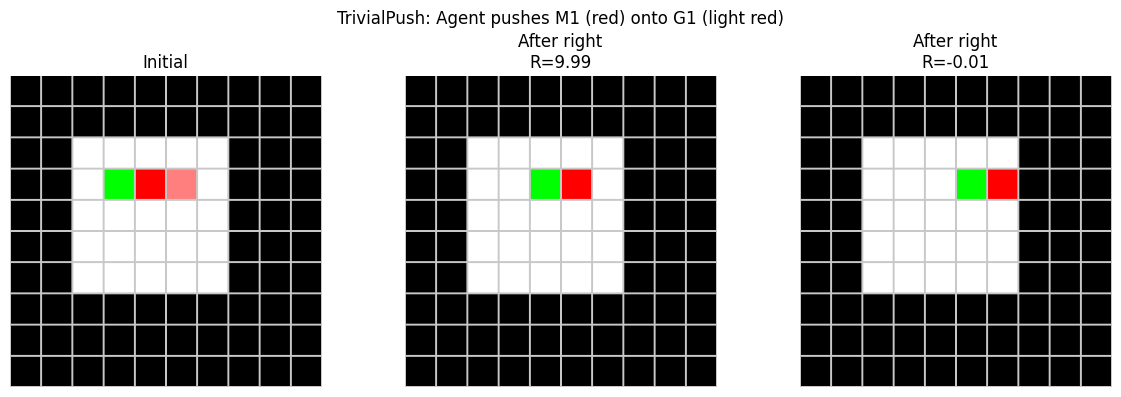


Total reward: 9.98
Episode done: False


In [8]:
# Reset to a simple level
level = Level.from_str(prefabs["TrivialPush"])
rng = jax.random.PRNGKey(0)
obs, state = env.reset_env_to_level(rng, level, env_params)

# Take a few steps
actions_to_take = [Actions.right, Actions.right]  # Move right twice to push M1 onto G1
frames = [renderer.render_state(state, env_params)]
rewards = []
dones = []

print("Episode Trace:")
print("=" * 40)
print("Step 0: Initial state")

for i, action in enumerate(actions_to_take):
    rng, step_rng = jax.random.split(rng)
    obs, state, reward, done, info = env.step_env(step_rng, state, action, env_params)
    frames.append(renderer.render_state(state, env_params))
    rewards.append(reward)
    dones.append(done)
    print(f"Step {i+1}: Action={action.name}, Reward={reward:.2f}, Done={done}")

# Visualize the trajectory
fig, axes = plt.subplots(1, len(frames), figsize=(4 * len(frames), 4))
for i, (ax, frame) in enumerate(zip(axes, frames)):
    ax.imshow(np.array(frame))
    if i == 0:
        ax.set_title("Initial")
    else:
        ax.set_title(f"After {actions_to_take[i-1].name}\nR={rewards[i-1]:.2f}")
    ax.axis("off")

plt.suptitle("TrivialPush: Agent pushes M1 (red) onto G1 (light red)", fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTotal reward: {sum(rewards):.2f}")
print(f"Episode done: {dones[-1]}")

## 4. The Neural Network (Actor-Critic)

Now let's understand the policy network. We use an Actor-Critic architecture with:
1. **CNN** to process the 10×10×8 observation grid
2. **LSTM** for temporal memory (important for puzzles!)
3. **Actor head** outputs action probabilities
4. **Critic head** outputs state value estimate

In [9]:
class PushWorldActorCritic(nn.Module):
    """Actor-Critic network for PushWorld environment.

    Architecture:
    - Input: (batch, H, W, 8) observation grid
    - Conv1: 32 filters, 3x3, SAME padding
    - Conv2: 64 filters, 3x3, SAME padding
    - Flatten: 10*10*64 = 6400
    - Dense: 256 units
    - LSTM: 256 hidden units (for memory)
    - Actor: 64 -> 4 (action logits)
    - Critic: 64 -> 1 (state value)
    """

    action_dim: int  # Number of actions (4 for PushWorld)

    @nn.compact
    def __call__(self, inputs, hidden):
        obs, dones = inputs

        # obs.image shape: (..., 10, 10, 8)
        img = obs.image

        # CNN embedding
        img_embed = nn.Conv(32, kernel_size=(3, 3), strides=(1, 1), padding="SAME")(img)
        img_embed = nn.relu(img_embed)
        img_embed = nn.Conv(64, kernel_size=(3, 3), strides=(1, 1), padding="SAME")(
            img_embed
        )
        img_embed = nn.relu(img_embed)
        img_embed = img_embed.reshape(*img_embed.shape[:-3], -1)  # Flatten spatial

        # Dense layer
        embedding = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(img_embed)
        embedding = nn.relu(embedding)

        # LSTM for temporal memory
        hidden, embedding = ResetRNN(nn.OptimizedLSTMCell(features=256))(
            (embedding, dones), initial_carry=hidden
        )

        # Actor head
        actor = nn.Dense(64, kernel_init=orthogonal(2), bias_init=constant(0.0))(
            embedding
        )
        actor = nn.relu(actor)
        actor_logits = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor)
        pi = distrax.Categorical(logits=actor_logits)

        # Critic head
        critic = nn.Dense(64, kernel_init=orthogonal(2), bias_init=constant(0.0))(
            embedding
        )
        critic = nn.relu(critic)
        value = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return hidden, pi, jnp.squeeze(value, axis=-1)

    @staticmethod
    def initialize_carry(batch_dims):
        """Initialize LSTM hidden state."""
        return nn.OptimizedLSTMCell(features=256).initialize_carry(
            jax.random.PRNGKey(0), (*batch_dims, 256)
        )


print("PushWorldActorCritic network defined!")
print(f"Action dimension: {len(Actions)} actions")

PushWorldActorCritic network defined!
Action dimension: 4 actions


### 4.1 Initialize and Test the Network

Let's create the network and see what the output shapes look like.

In [10]:
# Create the network
network = PushWorldActorCritic(action_dim=len(Actions))

# Create a dummy input to initialize parameters
# Shape: (seq_len, batch_size, H, W, channels)
batch_size = config["num_train_envs"]
seq_len = config["num_steps"]

# Get a single observation
rng = jax.random.PRNGKey(0)
level = sample_random_level(rng)
obs, state = env.reset_env_to_level(rng, level, env_params)

# Expand to batch: (seq_len, batch_size, 10, 10, 8)
obs_batch = jax.tree_util.tree_map(
    lambda x: jnp.repeat(
        jnp.repeat(x[None, ...], batch_size, axis=0)[None, ...], seq_len, axis=0
    ),
    obs,
)
dones_batch = jnp.zeros((seq_len, batch_size), dtype=jnp.bool_)

print("Input shapes:")
print(f"  obs.image: {obs_batch.image.shape} (seq_len, batch, H, W, channels)")
print(f"  dones: {dones_batch.shape} (seq_len, batch)")

# Initialize hidden state
init_hstate = PushWorldActorCritic.initialize_carry((batch_size,))
print("\nLSTM hidden state shapes:")
print(f"  c (cell state): {init_hstate[0].shape}")
print(f"  h (hidden state): {init_hstate[1].shape}")

# Initialize network parameters
rng, init_rng = jax.random.split(rng)
params = network.init(init_rng, (obs_batch, dones_batch), init_hstate)


# Count parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))


print(f"\nTotal parameters: {count_params(params):,}")

Input shapes:
  obs.image: (256, 32, 10, 10, 8) (seq_len, batch, H, W, channels)
  dones: (256, 32) (seq_len, batch)

LSTM hidden state shapes:
  c (cell state): (32, 256)
  h (hidden state): (32, 256)

Total parameters: 2,218,021


In [11]:
# Forward pass
new_hstate, pi, values = network.apply(params, (obs_batch, dones_batch), init_hstate)

print("Output shapes:")
print(f"  new_hstate[0] (c): {new_hstate[0].shape}")
print(f"  new_hstate[1] (h): {new_hstate[1].shape}")
print(f"  values: {values.shape} (seq_len, batch)")

print("\nPolicy distribution (for first timestep, first env):")
print(f"  Logits: {pi.logits[0, 0]}")
print(f"  Probs: {jax.nn.softmax(pi.logits[0, 0])}")
print(
    f"  Actions: up={jax.nn.softmax(pi.logits[0, 0])[0]:.2%}, right={jax.nn.softmax(pi.logits[0, 0])[1]:.2%}, down={jax.nn.softmax(pi.logits[0, 0])[2]:.2%}, left={jax.nn.softmax(pi.logits[0, 0])[3]:.2%}"
)

print(f"\nValue estimate (first timestep, first env): {values[0, 0]:.4f}")

Output shapes:
  new_hstate[0] (c): (32, 256)
  new_hstate[1] (h): (32, 256)
  values: (256, 32) (seq_len, batch)

Policy distribution (for first timestep, first env):
  Logits: [-1.3861334 -1.3861511 -1.3866106 -1.3862823]
  Probs: [0.25004023 0.25003582 0.24992095 0.250003  ]
  Actions: up=25.00%, right=25.00%, down=24.99%, left=25.00%

Value estimate (first timestep, first env): -0.0211


## 5. The TrainState

The `TrainState` bundles everything needed for training:
- Network parameters
- Optimizer state
- **Level sampler state** (PLR buffer!)
- Logging counters

In [12]:
class UpdateState(IntEnum):
    """Which type of update did we just do?"""

    DR = 0  # Domain Randomization (new levels)
    REPLAY = 1  # Replay from buffer


class TrainState(BaseTrainState):
    """Extended TrainState that includes PLR level sampler."""

    # The level sampler (PLR buffer) - this is the key PLR component!
    sampler: core.FrozenDict[str, chex.ArrayTree] = struct.field(pytree_node=True)

    # Track what type of update we just did (for ACCEL)
    update_state: UpdateState = struct.field(pytree_node=True)

    # Logging counters
    num_dr_updates: int
    num_replay_updates: int
    num_mutation_updates: int

    # Store last level batches for visualization
    dr_last_level_batch: chex.ArrayTree = struct.field(pytree_node=True)
    replay_last_level_batch: chex.ArrayTree = struct.field(pytree_node=True)
    mutation_last_level_batch: chex.ArrayTree = struct.field(pytree_node=True)


print("TrainState class defined!")
print("Key components:")
print("  - params: network parameters")
print("  - opt_state: optimizer state")
print("  - sampler: PLR level buffer")
print("  - update counters: track DR vs replay updates")

TrainState class defined!
Key components:
  - params: network parameters
  - opt_state: optimizer state
  - sampler: PLR level buffer
  - update counters: track DR vs replay updates


## 6. The Level Sampler (PLR Buffer)

This is the **heart of PLR**! The level sampler:
1. Stores levels with their scores
2. Samples levels based on scores (high-scoring = harder levels)
3. Handles staleness (levels not seen recently get boosted)

In [13]:
# Create the level sampler
level_sampler = LevelSampler(
    capacity=config["level_buffer_capacity"],  # Max 4000 levels
    replay_prob=config["replay_prob"],  # 80% replay, 20% new levels
    staleness_coeff=config["staleness_coeff"],  # Boost old levels
    minimum_fill_ratio=config[
        "minimum_fill_ratio"
    ],  # Wait until 50% full before replay
    prioritization=config["prioritization"],  # "rank" or "topk"
    prioritization_params={
        "temperature": config["temperature"],
        "k": config["topk_k"],
    },
    duplicate_check=config["buffer_duplicate_check"],
)

print("Level Sampler Configuration")
print("=" * 40)
print(f"Buffer capacity: {config['level_buffer_capacity']} levels")
print(f"Replay probability: {config['replay_prob']:.0%}")
print(f"Minimum fill ratio: {config['minimum_fill_ratio']:.0%}")
print(
    f"  → Buffer needs {int(config['level_buffer_capacity'] * config['minimum_fill_ratio'])} levels before replay"
)
print(f"Staleness coefficient: {config['staleness_coeff']}")
print(f"Prioritization: {config['prioritization']}")
print(f"Temperature: {config['temperature']}")

Level Sampler Configuration
Buffer capacity: 4000 levels
Replay probability: 80%
Minimum fill ratio: 50%
  → Buffer needs 2000 levels before replay
Staleness coefficient: 0.3
Prioritization: rank
Temperature: 0.3


### 6.1 Initialize the Level Sampler

Let's see what the sampler state looks like.

In [14]:
# Initialize with a placeholder level
rng = jax.random.PRNGKey(0)
placeholder_level = sample_random_level(rng)

sampler_state = level_sampler.initialize(
    placeholder_level,
    {"max_return": -jnp.inf},  # Extra data stored per level
)

print("Sampler State Structure:")
print("=" * 40)
for key, value in sampler_state.items():
    if isinstance(value, jnp.ndarray):
        print(f"  {key}: shape={value.shape}, dtype={value.dtype}")
    else:
        print(f"  {key}: {type(value).__name__}")

print()
print(f"Current buffer size: {sampler_state['size']}")
print(f"Episode count: {sampler_state['episode_count']}")
print(f"Scores shape: {sampler_state['scores'].shape} (one score per slot)")

Sampler State Structure:
  levels: Level
  scores: shape=(4000,), dtype=float32
  timestamps: shape=(4000,), dtype=int32
  size: int
  episode_count: int
  levels_extra: dict

Current buffer size: 0
Episode count: 0
Scores shape: (4000,) (one score per slot)


### 6.2 Inserting Levels into the Buffer

When we generate new levels, we compute a **score** for each and insert them into the buffer.

In [15]:
# Generate a batch of levels
rng = jax.random.PRNGKey(42)
batch_size = 10
rngs = jax.random.split(rng, batch_size)
level_batch = jax.vmap(sample_random_level)(rngs)

# Simulate scores (in practice, these come from the policy's performance)
# High score = level is challenging (agent learning a lot)
fake_scores = jax.random.uniform(jax.random.PRNGKey(0), (batch_size,))
fake_max_returns = jnp.zeros(batch_size) + 0.5

print("Inserting batch of levels:")
print(f"  Batch size: {batch_size}")
print(f"  Scores: {fake_scores}")

# Insert into buffer
sampler_state, inserted_indices = level_sampler.insert_batch(
    sampler_state, level_batch, fake_scores, {"max_return": fake_max_returns}
)

print("\nAfter insertion:")
print(f"  Buffer size: {sampler_state['size']}")
print(f"  Inserted at indices: {inserted_indices}")
print(f"  Scores in buffer: {sampler_state['scores'][:batch_size]}")

Inserting batch of levels:
  Batch size: 10
  Scores: [0.947667   0.9785799  0.33229148 0.46866846 0.5698887  0.16550303
 0.3101946  0.68948054 0.74676657 0.17101455]

After insertion:
  Buffer size: 10
  Inserted at indices: [0 1 2 3 4 5 6 7 8 9]
  Scores in buffer: [0.947667   0.9785799  0.33229148 0.46866846 0.5698887  0.16550303
 0.3101946  0.68948054 0.74676657 0.17101455]


## 7. GAE: Generalized Advantage Estimation

Before we can do PPO updates, we need to compute **advantages**. GAE smoothly combines:
- **TD(0)**: Low variance, high bias  
- **Monte Carlo**: High variance, low bias

The formula: `δ_t = r_t + γ * V(s_{t+1}) - V(s_t)`  
`A_t = δ_t + (γλ) * δ_{t+1} + (γλ)² * δ_{t+2} + ...`

In [16]:
def compute_gae(
    gamma: float,
    lambd: float,
    last_value: chex.Array,
    values: chex.Array,
    rewards: chex.Array,
    dones: chex.Array,
) -> Tuple[chex.Array, chex.Array]:
    """Compute Generalized Advantage Estimation.

    Args:
        gamma: Discount factor (default 0.995)
        lambd: GAE lambda (default 0.98)
        last_value: Value of last state, shape (NUM_ENVS,)
        values: Values for each step, shape (NUM_STEPS, NUM_ENVS)
        rewards: Rewards for each step, shape (NUM_STEPS, NUM_ENVS)
        dones: Done flags for each step, shape (NUM_STEPS, NUM_ENVS)

    Returns:
        advantages: shape (NUM_STEPS, NUM_ENVS)
        targets: shape (NUM_STEPS, NUM_ENVS) = advantages + values
    """

    def compute_gae_at_timestep(carry, x):
        gae, next_value = carry
        value, reward, done = x

        # TD error
        delta = reward + gamma * next_value * (1 - done) - value
        # GAE accumulation
        gae = delta + gamma * lambd * (1 - done) * gae

        return (gae, value), gae

    # Scan backwards through time
    _, advantages = jax.lax.scan(
        compute_gae_at_timestep,
        (jnp.zeros_like(last_value), last_value),
        (values, rewards, dones),
        reverse=True,  # Important! We scan backwards
        unroll=16,
    )

    # Targets for value function = advantages + values
    return advantages, advantages + values


print("compute_gae function defined!")
print("Hyperparameters:")
print(f"  gamma (discount): {config['gamma']}")
print(f"  lambda (GAE): {config['gae_lambda']}")

compute_gae function defined!
Hyperparameters:
  gamma (discount): 0.995
  lambda (GAE): 0.98


## 8. Trajectory Sampling (Rollouts)

We need to collect trajectories from the environment to train on. This involves:
1. Reset environments to levels
2. Run policy for `num_steps` steps
3. Collect (obs, action, reward, done, log_prob, value) tuples

In [17]:
def sample_trajectories_rnn(
    rng: chex.PRNGKey,
    env,
    env_params: EnvParams,
    train_state: TrainState,
    init_hstate: chex.ArrayTree,
    init_obs: Observation,
    init_env_state: EnvState,
    num_envs: int,
    max_episode_length: int,
):
    """Sample trajectories using the RNN policy.

    This is the main rollout function. It runs the policy for max_episode_length
    steps across num_envs parallel environments.

    Returns:
        final_carry: (rng, train_state, hstate, last_obs, last_env_state, last_value)
        trajectories: (obs, actions, rewards, dones, log_probs, values, info)
    """

    def sample_step(carry, _):
        rng, train_state, hstate, obs, env_state, last_done = carry
        rng, rng_action, rng_step = jax.random.split(rng, 3)

        # Add sequence dimension for network
        x = jax.tree_util.tree_map(lambda x: x[None, ...], (obs, last_done))

        # Forward pass through network
        hstate, pi, value = train_state.apply_fn(train_state.params, x, hstate)

        # Sample action from policy
        action = pi.sample(seed=rng_action)
        log_prob = pi.log_prob(action)

        # Remove sequence dimension
        value, action, log_prob = (
            value.squeeze(0),
            action.squeeze(0),
            log_prob.squeeze(0),
        )

        # Step all environments in parallel
        next_obs, env_state, reward, done, info = jax.vmap(
            env.step, in_axes=(0, 0, 0, None)
        )(jax.random.split(rng_step, num_envs), env_state, action, env_params)

        carry = (rng, train_state, hstate, next_obs, env_state, done)
        return carry, (obs, action, reward, done, log_prob, value, info)

    # Run the rollout
    (rng, train_state, hstate, last_obs, last_env_state, last_done), traj = (
        jax.lax.scan(
            sample_step,
            (
                rng,
                train_state,
                init_hstate,
                init_obs,
                init_env_state,
                jnp.zeros(num_envs, dtype=bool),
            ),
            None,
            length=max_episode_length,
        )
    )

    # Get value of final state (for GAE computation)
    x = jax.tree_util.tree_map(lambda x: x[None, ...], (last_obs, last_done))
    _, _, last_value = train_state.apply_fn(train_state.params, x, hstate)

    return (
        rng,
        train_state,
        hstate,
        last_obs,
        last_env_state,
        last_value.squeeze(0),
    ), traj


print("sample_trajectories_rnn function defined!")
print("\nRollout configuration:")
print(f"  num_envs: {config['num_train_envs']}")
print(f"  num_steps: {config['num_steps']}")
print(
    f"  Total transitions per rollout: {config['num_train_envs'] * config['num_steps']:,}"
)

sample_trajectories_rnn function defined!

Rollout configuration:
  num_envs: 32
  num_steps: 256
  Total transitions per rollout: 8,192


## 9. PPO Update

PPO (Proximal Policy Optimization) is our policy gradient algorithm. Key ideas:
1. **Clipped surrogate objective**: Prevents too-large policy updates
2. **Value function loss**: Train critic to predict returns
3. **Entropy bonus**: Encourage exploration

In [18]:
def update_actor_critic_rnn(
    rng: chex.PRNGKey,
    train_state: TrainState,
    init_hstate: chex.ArrayTree,
    batch: chex.ArrayTree,
    num_envs: int,
    n_steps: int,
    n_minibatch: int,
    n_epochs: int,
    clip_eps: float,
    entropy_coeff: float,
    critic_coeff: float,
    update_grad: bool = True,
):
    """Update the actor-critic network using PPO.

    Args:
        batch: (obs, actions, dones, log_probs, values, targets, advantages)
        update_grad: If False, compute losses but don't update params (for DR in robust PLR)
    """
    obs, actions, dones, log_probs, values, targets, advantages = batch

    # Shift dones to get "last_done" (done from previous step)
    last_dones = jnp.roll(dones, 1, axis=0).at[0].set(False)
    batch = obs, actions, last_dones, log_probs, values, targets, advantages

    def update_epoch(carry, _):
        """One epoch of PPO updates over all minibatches."""

        def update_minibatch(train_state, minibatch):
            """Update on a single minibatch."""
            (
                init_hstate,
                obs,
                actions,
                last_dones,
                log_probs,
                values,
                targets,
                advantages,
            ) = minibatch

            def loss_fn(params):
                # Forward pass
                _, pi, values_pred = train_state.apply_fn(
                    params, (obs, last_dones), init_hstate
                )
                log_probs_pred = pi.log_prob(actions)
                entropy = pi.entropy().mean()

                # PPO clipped objective
                ratio = jnp.exp(log_probs_pred - log_probs)
                A = (advantages - advantages.mean()) / (
                    advantages.std() + 1e-5
                )  # Normalize
                l_clip = -jnp.minimum(
                    ratio * A, jnp.clip(ratio, 1 - clip_eps, 1 + clip_eps) * A
                ).mean()

                # Clipped value loss
                values_pred_clipped = values + (values_pred - values).clip(
                    -clip_eps, clip_eps
                )
                l_vf = (
                    0.5
                    * jnp.maximum(
                        (values_pred - targets) ** 2,
                        (values_pred_clipped - targets) ** 2,
                    ).mean()
                )

                # Total loss
                loss = l_clip + critic_coeff * l_vf - entropy_coeff * entropy

                return loss, (l_vf, l_clip, entropy)

            grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
            loss, grads = grad_fn(train_state.params)
            if update_grad:
                train_state = train_state.apply_gradients(grads=grads)
            return train_state, loss

        rng, train_state = carry
        rng, rng_perm = jax.random.split(rng)

        # Shuffle and create minibatches
        permutation = jax.random.permutation(rng_perm, num_envs)
        minibatches = (
            jax.tree_util.tree_map(
                lambda x: jnp.take(x, permutation, axis=0).reshape(
                    n_minibatch, -1, *x.shape[1:]
                ),
                init_hstate,
            ),
            *jax.tree_util.tree_map(
                lambda x: jnp.take(x, permutation, axis=1)
                .reshape(x.shape[0], n_minibatch, -1, *x.shape[2:])
                .swapaxes(0, 1),
                batch,
            ),
        )
        train_state, losses = jax.lax.scan(update_minibatch, train_state, minibatches)
        return (rng, train_state), losses

    return jax.lax.scan(update_epoch, (rng, train_state), None, n_epochs)


print("update_actor_critic_rnn function defined!")
print("\nPPO configuration:")
print(f"  clip_eps: {config['clip_eps']}")
print(f"  n_epochs: {config['epoch_ppo']}")
print(f"  n_minibatches: {config['num_minibatches']}")
print(f"  entropy_coeff: {config['entropy_coeff']}")
print(f"  critic_coeff: {config['critic_coeff']}")

update_actor_critic_rnn function defined!

PPO configuration:
  clip_eps: 0.2
  n_epochs: 5
  n_minibatches: 1
  entropy_coeff: 0.001
  critic_coeff: 0.5


## 10. Level Scoring (The PLR Magic)

This is where PLR gets interesting! We need to score each level to determine how useful it is for training.

**MaxMC** (Maximum Monte-Carlo): max(V - V_max) over an episode
- High score means agent thinks level is valuable but actual returns were bad
- Indicates learning opportunity!

**Positive Value Loss (pvl)**: mean(max(0, A)) over episode
- Measures positive advantages (when actions were better than expected)

In [19]:
def compute_score(config, dones, values, max_returns, advantages):
    """Compute PLR score for levels.

    Args:
        dones: (num_steps, num_envs) - done flags
        values: (num_steps, num_envs) - value estimates
        max_returns: (num_envs,) - maximum return achieved
        advantages: (num_steps, num_envs) - GAE advantages

    Returns:
        scores: (num_envs,) - one score per level
    """
    if config["score_function"] == "MaxMC":
        # max_mc computes: max_t (V_t - max_return)
        # High when agent overestimates value vs actual performance
        return max_mc(dones, values, max_returns)
    elif config["score_function"] == "pvl":
        # positive_value_loss: mean of positive advantages
        return positive_value_loss(dones, advantages)
    else:
        raise ValueError(f"Unknown score function: {config['score_function']}")


print(f"Score function: {config['score_function']}")
print()
print("Intuition:")
print("  - High score = agent is learning from this level")
print("  - Low score = agent already mastered it (or it's impossible)")
print("  - PLR prioritizes high-scoring levels for replay")

Score function: MaxMC

Intuition:
  - High score = agent is learning from this level
  - Low score = agent already mastered it (or it's impossible)
  - PLR prioritizes high-scoring levels for replay


## 11. Create the TrainState

Now let's put it all together and create the initial training state.

In [ ]:
# Wrap environment for auto-replay (resets to same level when done)
wrapped_env = AutoReplayWrapper(env)


def create_train_state(rng) -> TrainState:
    """Initialize all components for training."""

    # Learning rate schedule: linear decay
    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["num_minibatches"] * config["epoch_ppo"]))
            / config["num_updates"]
        )
        return config["lr"] * frac

    # Create dummy observation for network initialization
    rng, rng_level, rng_reset = jax.random.split(rng, 3)
    dummy_level = sample_random_level(rng_level)
    obs, _ = wrapped_env.reset_to_level(rng_reset, dummy_level, env_params)

    # Expand to batch shape
    obs = jax.tree_util.tree_map(
        lambda x: jnp.repeat(
            jnp.repeat(x[None, ...], config["num_train_envs"], axis=0)[None, ...],
            config["num_steps"],
            axis=0,
        ),
        obs,
    )
    init_x = (obs, jnp.zeros((config["num_steps"], config["num_train_envs"])))

    # Initialize network
    network = PushWorldActorCritic(len(Actions))
    rng, rng_init = jax.random.split(rng)
    network_params = network.init(
        rng_init,
        init_x,
        PushWorldActorCritic.initialize_carry((config["num_train_envs"],)),
    )

    # Optimizer
    tx = optax.chain(
        optax.clip_by_global_norm(config["max_grad_norm"]),
        optax.adam(learning_rate=linear_schedule, eps=1e-5),
    )

    # Initialize level sampler
    placeholder_level = sample_random_level(jax.random.PRNGKey(0))
    sampler = level_sampler.initialize(placeholder_level, {"max_return": -jnp.inf})

    # Placeholder level batch
    placeholder_level_batch = jax.tree_util.tree_map(
        lambda x: jnp.array([x]).repeat(config["num_train_envs"], axis=0),
        placeholder_level,
    )

    return TrainState.create(
        apply_fn=network.apply,
        params=network_params,
        tx=tx,
        sampler=sampler,
        update_state=0,
        num_dr_updates=0,
        num_replay_updates=0,
        num_mutation_updates=0,
        dr_last_level_batch=placeholder_level_batch,
        replay_last_level_batch=placeholder_level_batch,
        mutation_last_level_batch=placeholder_level_batch,
    )


# Create the initial train state
rng = jax.random.PRNGKey(config["seed"])
rng, rng_init = jax.random.split(rng)
train_state = create_train_state(rng_init)

print("TrainState created!")
print(f"  Network params: {count_params(train_state.params):,}")
print(f"  Sampler buffer size: {train_state.sampler['size']}")
print(f"  DR updates: {train_state.num_dr_updates}")
print(f"  Replay updates: {train_state.num_replay_updates}")

## 12. The PLR Training Loop

The PLR training loop has three branches:
1. **on_new_levels** (Domain Randomization): Generate new random levels, score them, add to buffer
2. **on_replay_levels**: Sample levels from buffer, train on them, update scores
3. **on_mutate_levels** (ACCEL only): Mutate replay levels to create variations

The choice between branches depends on:
- Buffer fill ratio (need minimum fill before replay)
- Replay probability (80% replay vs 20% new levels)

### 12.1 on_new_levels: Domain Randomization

This function generates new random levels and adds them to the buffer.

In [ ]:
def on_new_levels(rng: chex.PRNGKey, train_state: TrainState):
    """Generate new random levels, evaluate policy, score and add to buffer.

    This is the 'Domain Randomization' branch of PLR.
    In Robust PLR, we DON'T update gradients on these levels.
    """
    sampler = train_state.sampler

    # Step 1: Generate new random levels
    rng, rng_levels, rng_reset = jax.random.split(rng, 3)
    new_levels = jax.vmap(sample_random_level)(
        jax.random.split(rng_levels, config["num_train_envs"])
    )

    # Step 2: Reset environments to these levels
    init_obs, init_env_state = jax.vmap(
        wrapped_env.reset_to_level, in_axes=(0, 0, None)
    )(
        jax.random.split(rng_reset, config["num_train_envs"]),
        new_levels,
        env_params,
    )

    # Step 3: Collect trajectories
    (
        (rng, train_state, hstate, last_obs, last_env_state, last_value),
        (obs, actions, rewards, dones, log_probs, values, info),
    ) = sample_trajectories_rnn(
        rng,
        wrapped_env,
        env_params,
        train_state,
        PushWorldActorCritic.initialize_carry((config["num_train_envs"],)),
        init_obs,
        init_env_state,
        config["num_train_envs"],
        config["num_steps"],
    )

    # Step 4: Compute advantages and scores
    advantages, targets = compute_gae(
        config["gamma"], config["gae_lambda"], last_value, values, rewards, dones
    )
    max_returns = compute_max_returns(dones, rewards)
    scores = compute_score(config, dones, values, max_returns, advantages)

    # Step 5: Insert levels into buffer
    sampler, _ = level_sampler.insert_batch(
        sampler, new_levels, scores, {"max_return": max_returns}
    )

    # Step 6: Update policy (only if exploratory_grad_updates is True)
    (rng, train_state), losses = update_actor_critic_rnn(
        rng,
        train_state,
        PushWorldActorCritic.initialize_carry((config["num_train_envs"],)),
        (obs, actions, dones, log_probs, values, targets, advantages),
        config["num_train_envs"],
        config["num_steps"],
        config["num_minibatches"],
        config["epoch_ppo"],
        config["clip_eps"],
        config["entropy_coeff"],
        config["critic_coeff"],
        update_grad=config["exploratory_grad_updates"],  # False for Robust PLR!
    )

    # Update train state
    train_state = train_state.replace(
        sampler=sampler,
        update_state=UpdateState.DR,
        num_dr_updates=train_state.num_dr_updates + 1,
        dr_last_level_batch=new_levels,
    )

    return (rng, train_state), {"scores": scores, "rewards": rewards}


print("on_new_levels function defined!")
print(f"  exploratory_grad_updates: {config['exploratory_grad_updates']}")
print(
    "  → Gradients will {'be' if config['exploratory_grad_updates'] else 'NOT be'} applied on DR levels"
)

### 12.2 on_replay_levels: Replay from Buffer

This function samples levels from the buffer and trains on them. This is where the actual learning happens!

In [ ]:
def on_replay_levels(rng: chex.PRNGKey, train_state: TrainState):
    """Sample levels from buffer, train policy, update scores.

    This is where the actual learning happens in PLR!
    """
    sampler = train_state.sampler

    # Step 1: Sample levels from buffer (weighted by score)
    rng, rng_levels, rng_reset = jax.random.split(rng, 3)
    sampler, (level_inds, levels) = level_sampler.sample_replay_levels(
        sampler, rng_levels, config["num_train_envs"]
    )

    # Step 2: Reset environments to sampled levels
    init_obs, init_env_state = jax.vmap(
        wrapped_env.reset_to_level, in_axes=(0, 0, None)
    )(
        jax.random.split(rng_reset, config["num_train_envs"]),
        levels,
        env_params,
    )

    # Step 3: Collect trajectories
    (
        (rng, train_state, hstate, last_obs, last_env_state, last_value),
        (obs, actions, rewards, dones, log_probs, values, info),
    ) = sample_trajectories_rnn(
        rng,
        wrapped_env,
        env_params,
        train_state,
        PushWorldActorCritic.initialize_carry((config["num_train_envs"],)),
        init_obs,
        init_env_state,
        config["num_train_envs"],
        config["num_steps"],
    )

    # Step 4: Compute advantages and update scores
    advantages, targets = compute_gae(
        config["gamma"], config["gae_lambda"], last_value, values, rewards, dones
    )

    # Keep track of best return seen on each level
    max_returns = jnp.maximum(
        level_sampler.get_levels_extra(sampler, level_inds)["max_return"],
        compute_max_returns(dones, rewards),
    )
    scores = compute_score(config, dones, values, max_returns, advantages)

    # Update scores in buffer
    sampler = level_sampler.update_batch(
        sampler, level_inds, scores, {"max_return": max_returns}
    )

    # Step 5: Update policy (ALWAYS apply gradients on replay!)
    (rng, train_state), losses = update_actor_critic_rnn(
        rng,
        train_state,
        PushWorldActorCritic.initialize_carry((config["num_train_envs"],)),
        (obs, actions, dones, log_probs, values, targets, advantages),
        config["num_train_envs"],
        config["num_steps"],
        config["num_minibatches"],
        config["epoch_ppo"],
        config["clip_eps"],
        config["entropy_coeff"],
        config["critic_coeff"],
        update_grad=True,  # Always update on replay levels!
    )

    # Update train state
    train_state = train_state.replace(
        sampler=sampler,
        update_state=UpdateState.REPLAY,
        num_replay_updates=train_state.num_replay_updates + 1,
        replay_last_level_batch=levels,
    )

    return (rng, train_state), {
        "scores": scores,
        "rewards": rewards,
        "level_inds": level_inds,
    }


print("on_replay_levels function defined!")
print("  → Gradients are ALWAYS applied on replay levels")

### 12.3 The Main Train Step

The train step decides which branch to take based on buffer state and randomness.

In [ ]:
def train_step(carry, _):
    """One step of PLR training.

    Decides between:
    - on_new_levels (DR): Generate new levels, add to buffer
    - on_replay_levels: Sample from buffer, train policy
    """
    rng, train_state = carry
    rng, rng_replay = jax.random.split(rng)

    # Decide: replay or generate new levels?
    # sample_replay_decision returns True if we should replay
    branch = level_sampler.sample_replay_decision(
        train_state.sampler, rng_replay
    ).astype(int)

    # branch = 0 -> on_new_levels (DR)
    # branch = 1 -> on_replay_levels
    return jax.lax.switch(
        branch,
        [on_new_levels, on_replay_levels],
        rng,
        train_state,
    )


print("train_step function defined!")
print()
print("Decision logic:")
print(
    f"  - Buffer min fill: {config['minimum_fill_ratio']:.0%} ({int(config['level_buffer_capacity'] * config['minimum_fill_ratio'])} levels)"
)
print(f"  - Replay probability: {config['replay_prob']:.0%}")
print("  - If buffer < min fill: always DR (new levels)")
print(
    "  - If buffer >= min fill: replay with {:.0%} probability".format(
        config["replay_prob"]
    )
)

## 13. Run a Few Training Steps

Let's actually run a few training steps and see what happens!

In [ ]:
# JIT compile the train step for speed
train_step_jit = jax.jit(train_step)

# Run a few training steps
n_steps = 5
runner_state = (rng, train_state)

print("Running training steps...")
print("=" * 50)

for i in range(n_steps):
    runner_state, metrics = train_step_jit(runner_state, None)
    rng, train_state = runner_state

    update_type = "DR" if train_state.update_state == UpdateState.DR else "REPLAY"
    print(f"Step {i+1}: {update_type}")
    print(f"  Buffer size: {train_state.sampler['size']}")
    print(f"  DR updates: {train_state.num_dr_updates}")
    print(f"  Replay updates: {train_state.num_replay_updates}")
    print(f"  Mean score: {metrics['scores'].mean():.4f}")
    print(f"  Mean reward: {metrics['rewards'].mean():.4f}")
    print()

### 13.1 Visualize Last Generated Levels

Let's see what levels are being generated.

In [ ]:
# Visualize some levels from the last DR batch
dr_levels = train_state.dr_last_level_batch
n_show = min(8, config["num_train_envs"])

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(n_show):
    # Get the i-th level
    level_i = jax.tree_util.tree_map(lambda x: x[i], dr_levels)
    obs, state = env.reset_env_to_level(jax.random.PRNGKey(0), level_i, env_params)
    img = renderer.render_state(state, env_params)

    axes[i].imshow(np.array(img))
    axes[i].set_title(f"Level {i+1}")
    axes[i].axis("off")

plt.suptitle("Last Domain Randomization Batch", fontsize=14)
plt.tight_layout()
plt.show()

## 14. Fill the Buffer and Start Replaying

The buffer needs to reach minimum_fill_ratio (50%) before replay starts. Let's run more steps to fill it.

In [ ]:
# Calculate how many steps needed to fill buffer to minimum
min_fill = int(config["level_buffer_capacity"] * config["minimum_fill_ratio"])
levels_per_step = config["num_train_envs"]
current_size = int(train_state.sampler["size"])
steps_needed = max(
    0, (min_fill - current_size) // levels_per_step + 10
)  # +10 extra to ensure replay

print(f"Current buffer size: {current_size}")
print(f"Minimum fill required: {min_fill}")
print(f"Levels added per step: {levels_per_step}")
print(f"Steps needed: {steps_needed}")
print()

# Run the steps using jax.lax.scan for efficiency
if steps_needed > 0:
    print(f"Running {steps_needed} steps to fill buffer...")

    # Use scan for efficiency
    @jax.jit
    def run_n_steps(runner_state, n):
        return jax.lax.scan(train_step, runner_state, None, length=n)

    runner_state, all_metrics = run_n_steps(runner_state, steps_needed)
    rng, train_state = runner_state

    print(f"Done! Buffer size: {train_state.sampler['size']}")
    print(f"Total DR updates: {train_state.num_dr_updates}")
    print(f"Total Replay updates: {train_state.num_replay_updates}")

### 14.1 Analyze the Buffer

Let's look at what's in the buffer now.

In [ ]:
# Analyze the buffer
sampler = train_state.sampler
buffer_size = int(sampler["size"])
scores = np.array(sampler["scores"][:buffer_size])

print("Buffer Statistics")
print("=" * 40)
print(f"Buffer size: {buffer_size}")
print(f"Score range: [{scores.min():.4f}, {scores.max():.4f}]")
print(f"Score mean: {scores.mean():.4f}")
print(f"Score std: {scores.std():.4f}")

# Plot score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram
axes[0].hist(scores, bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Level Scores in Buffer")
axes[0].axvline(
    scores.mean(), color="red", linestyle="--", label=f"Mean: {scores.mean():.3f}"
)
axes[0].legend()

# Sorted scores
axes[1].plot(np.sort(scores)[::-1])
axes[1].set_xlabel("Rank")
axes[1].set_ylabel("Score")
axes[1].set_title("Scores Sorted by Rank (Higher = More Learning Potential)")

plt.tight_layout()
plt.show()

### 14.2 Visualize Highest-Scoring Levels

These are the levels PLR thinks are most valuable for learning.

In [ ]:
# Get indices of top-scoring levels
top_k = 8
top_indices = np.argsort(scores)[::-1][:top_k]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, idx in enumerate(top_indices):
    # Get the level at this index
    level_i = level_sampler.get_levels(sampler, idx)
    obs, state = env.reset_env_to_level(jax.random.PRNGKey(0), level_i, env_params)
    img = renderer.render_state(state, env_params)

    axes[i].imshow(np.array(img))
    axes[i].set_title(f"Score: {scores[idx]:.4f}")
    axes[i].axis("off")

plt.suptitle("Top 8 Highest-Scoring Levels (Most Learning Potential)", fontsize=14)
plt.tight_layout()
plt.show()

print("These levels have high scores, meaning:")
print("  - The agent's value estimate was higher than actual returns")
print("  - There's room for the agent to learn from these levels")

## 15. Summary: The Complete PLR Pipeline

Here's the complete flow:

```
┌─────────────────────────────────────────────────────────────────┐
│                    PLR Training Loop                             │
├─────────────────────────────────────────────────────────────────┤
│                                                                  │
│  ┌──────────────┐    Is buffer full enough?                     │
│  │ train_step() │────────────────────────────────────┐          │
│  └──────────────┘                                     │          │
│         │                                             │          │
│         ▼ No (or 20% of time)                        ▼ Yes (80%)│
│  ┌──────────────────┐                    ┌───────────────────┐  │
│  │  on_new_levels() │                    │ on_replay_levels()│  │
│  │  (Domain Random) │                    │                   │  │
│  └──────────────────┘                    └───────────────────┘  │
│         │                                            │          │
│         ▼                                            ▼          │
│  1. Generate random levels              1. Sample from buffer   │
│  2. Collect trajectories                2. Collect trajectories │
│  3. Compute scores                      3. Update scores        │
│  4. Add to buffer                       4. PPO update (learn!)  │
│  5. (No PPO update in robust PLR)                               │
│                                                                  │
└─────────────────────────────────────────────────────────────────┘
```

### Key Takeaways:

1. **Level Buffer**: Stores levels with their PLR scores
2. **Score Function**: Measures learning potential (MaxMC or PVL)
3. **Replay Priority**: High-scoring levels get sampled more often
4. **Robust PLR**: Only update policy on replay levels, not DR levels
5. **Curriculum**: Agent naturally learns on progressively harder levels

## 16. Exercises to Try

Now that you understand the pipeline, try these experiments:

1. **Change the score function**: Set `config["score_function"] = "pvl"` and see how scores change

2. **Adjust replay probability**: Try `config["replay_prob"] = 0.5` (more exploration) or `0.95` (more exploitation)

3. **Enable exploratory gradients**: Set `config["exploratory_grad_updates"] = True` to also learn on DR levels

4. **Run longer training**: Run 100+ steps and watch the buffer evolve

5. **Compare with pure DR**: Set `config["replay_prob"] = 0.0` for no replay (baseline)

In [ ]:
# Continue training for more steps
n_more_steps = 50
print(f"Running {n_more_steps} more training steps...")

runner_state, all_metrics = run_n_steps(runner_state, n_more_steps)
rng, train_state = runner_state

print(f"\nAfter {n_more_steps} more steps:")
print(f"  Buffer size: {train_state.sampler['size']}")
print(f"  Total DR updates: {train_state.num_dr_updates}")
print(f"  Total Replay updates: {train_state.num_replay_updates}")
print(
    f"  Replay ratio: {train_state.num_replay_updates / (train_state.num_dr_updates + train_state.num_replay_updates + 1e-8):.1%}"
)

## 17. Evaluate on Test Levels

Let's see how well our agent performs on the evaluation levels.

In [ ]:
def evaluate_on_level(rng, train_state, level, level_name, max_steps=100):
    """Evaluate the trained policy on a specific level."""
    # Reset to level
    obs, state = env.reset_env_to_level(rng, level, env_params)
    hstate = PushWorldActorCritic.initialize_carry((1,))

    # Run episode
    frames = [renderer.render_state(state, env_params)]
    total_reward = 0
    done = False
    step = 0

    while not done and step < max_steps:
        rng, rng_action = jax.random.split(rng)

        # Get action from policy
        obs_batch = jax.tree_util.tree_map(lambda x: x[None, None, ...], obs)
        done_batch = jnp.array([[False]])
        hstate, pi, _ = train_state.apply_fn(
            train_state.params, (obs_batch, done_batch), hstate
        )
        action = pi.sample(seed=rng_action).squeeze()

        # Step environment
        rng, rng_step = jax.random.split(rng)
        obs, state, reward, done, info = env.step_env(
            rng_step, state, action, env_params
        )

        frames.append(renderer.render_state(state, env_params))
        total_reward += float(reward)
        step += 1

    return frames, total_reward, step, done


# Evaluate on each level
print("Evaluating on test levels...")
print("=" * 50)

eval_levels = config["eval_levels"]
results = {}

fig, axes = plt.subplots(1, len(eval_levels), figsize=(4 * len(eval_levels), 4))
if len(eval_levels) == 1:
    axes = [axes]

for i, level_name in enumerate(eval_levels):
    level = Level.from_str(prefabs[level_name])
    rng, rng_eval = jax.random.split(rng)
    frames, reward, steps, solved = evaluate_on_level(
        rng_eval, train_state, level, level_name
    )

    results[level_name] = {"reward": reward, "steps": steps, "solved": solved}

    # Show final frame
    axes[i].imshow(np.array(frames[-1]))
    axes[i].set_title(
        f"{level_name}\nR={reward:.2f}, Steps={steps}\n{'SOLVED!' if solved else 'Failed'}"
    )
    axes[i].axis("off")

    print(f"{level_name}: Reward={reward:.2f}, Steps={steps}, Solved={solved}")

plt.suptitle("Agent Performance on Evaluation Levels", fontsize=14)
plt.tight_layout()
plt.show()

print("\nNote: Agent has only trained for a short time!")
print("Full training (~30k updates) is needed for good performance.")

## 18. Running Full Training

To run full training with all features (wandb logging, checkpointing, etc.):

```bash
# From the experiments directory:
python pushworld_plr.py

# Or with custom config:
python pushworld_plr.py seed=123 num_updates=50000 use_wandb=True

# Use ACCEL (with level mutation):
python pushworld_plr.py ued=accel
```

The full training script includes:
- Wandb logging with metrics and visualizations
- Checkpointing for resuming training
- Parallel evaluation across multiple attempts
- Animation generation for evaluation episodes

Happy training! 🎮